In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd
import os
LOGS = 'logs'
DATA = 'origin_data_csv'
try:
    mort_match = pd.read_csv(os.path.join(LOGS,"mort_match.csv"))
    surv_match = pd.read_csv(os.path.join(LOGS,"surv_match.csv"))
    ICUSTAY = pd.read_csv(os.path.join(DATA,"ICUSTAYS.csv"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

target_cols = ['SUBJECT_ID','ICUSTAY_ID','HOSPITAL_EXPIRE_FLAG']
patients = pd.concat([mort_match[target_cols],surv_match[target_cols]],axis = 0)
patients = patients.merge(ICUSTAY[['ICUSTAY_ID','LOS']],on='ICUSTAY_ID',how='inner').drop_duplicates()

# LOS : unit day, how long the patient stayed in the ICU
# Turn LOS unit from day in hour
patients['LOS'] = (patients['LOS'] * 24).astype(int)
patients['HOSPITAL_EXPIRE_FLAG'] = patients['HOSPITAL_EXPIRE_FLAG'].astype(bool)
print(patients.head())
patients.to_csv(os.path.join("patients.csv"),index=False)


   SUBJECT_ID  ICUSTAY_ID  HOSPITAL_EXPIRE_FLAG  LOS
0         491      235261                  True   41
1         773      213086                  True  663
2        1049      264612                  True  142
3        2586      258569                  True  351
4        3171      204315                  True   17


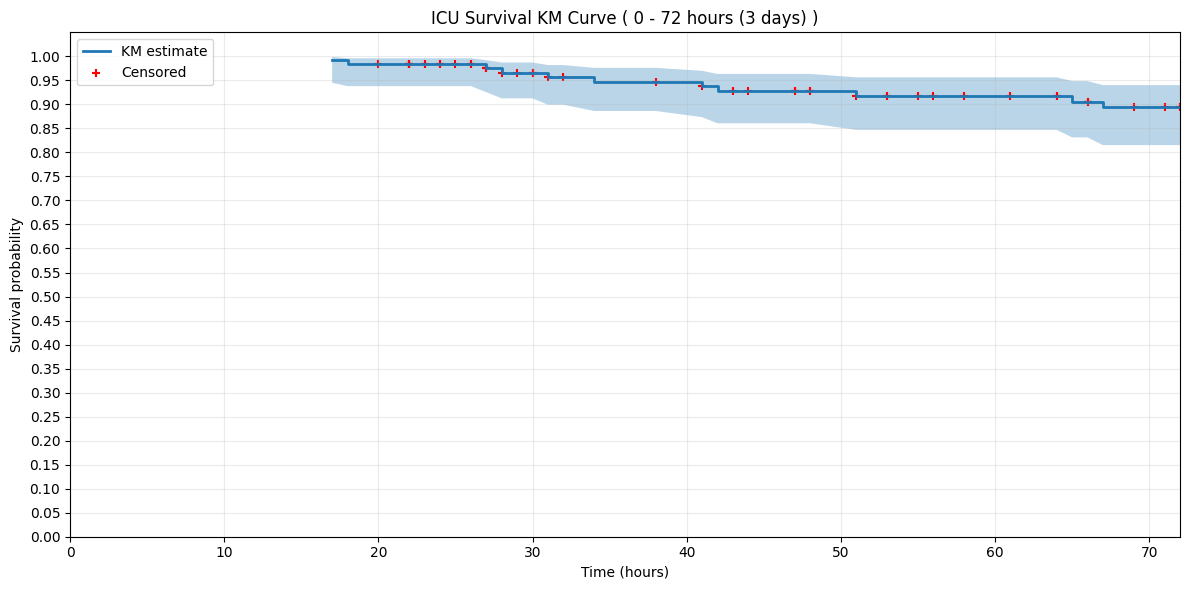

<Figure size 640x480 with 0 Axes>

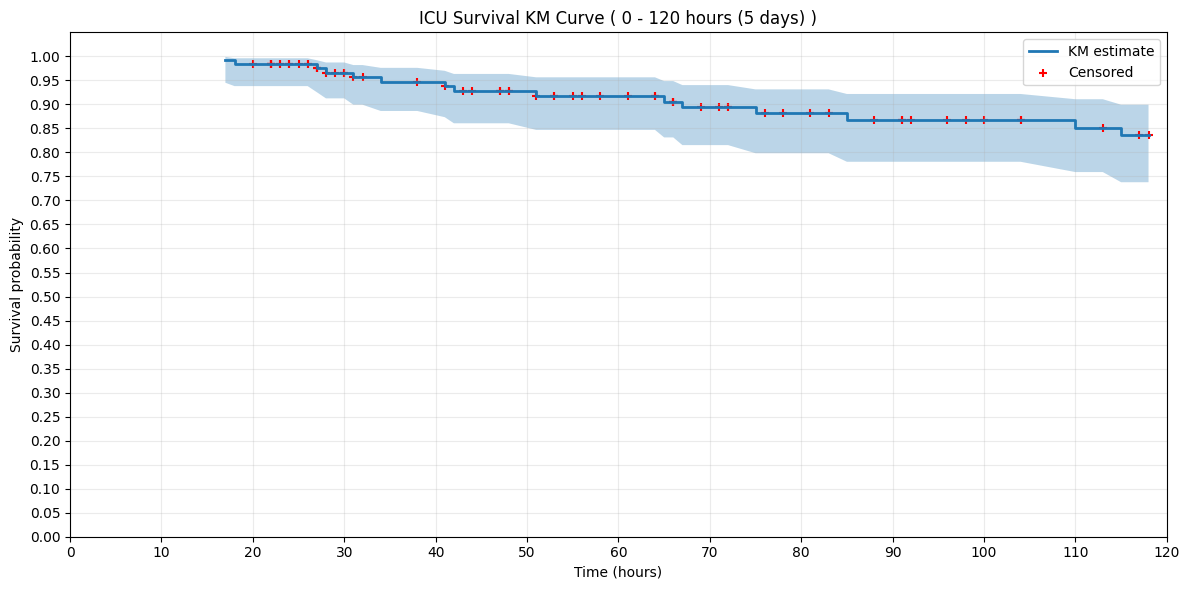

<Figure size 640x480 with 0 Axes>

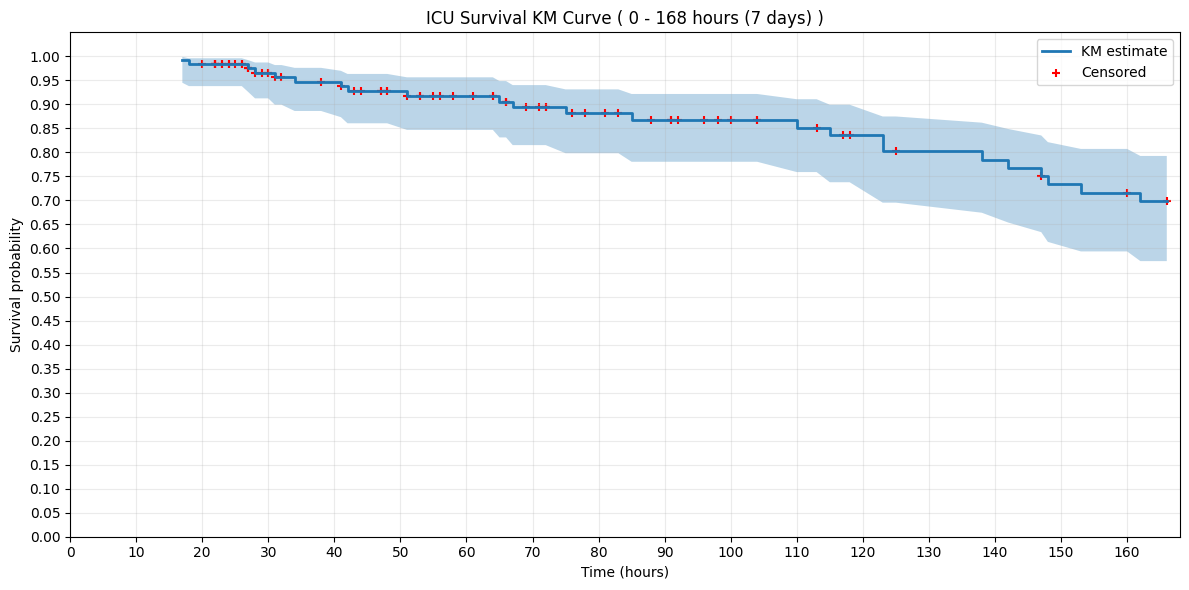

<Figure size 640x480 with 0 Axes>

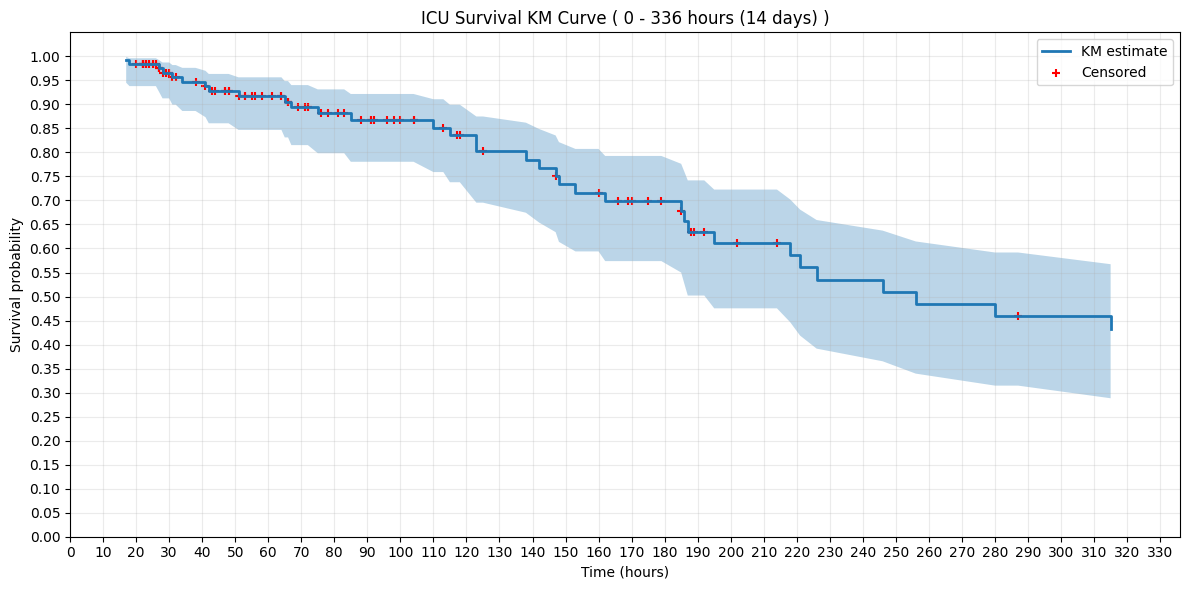

<Figure size 640x480 with 0 Axes>

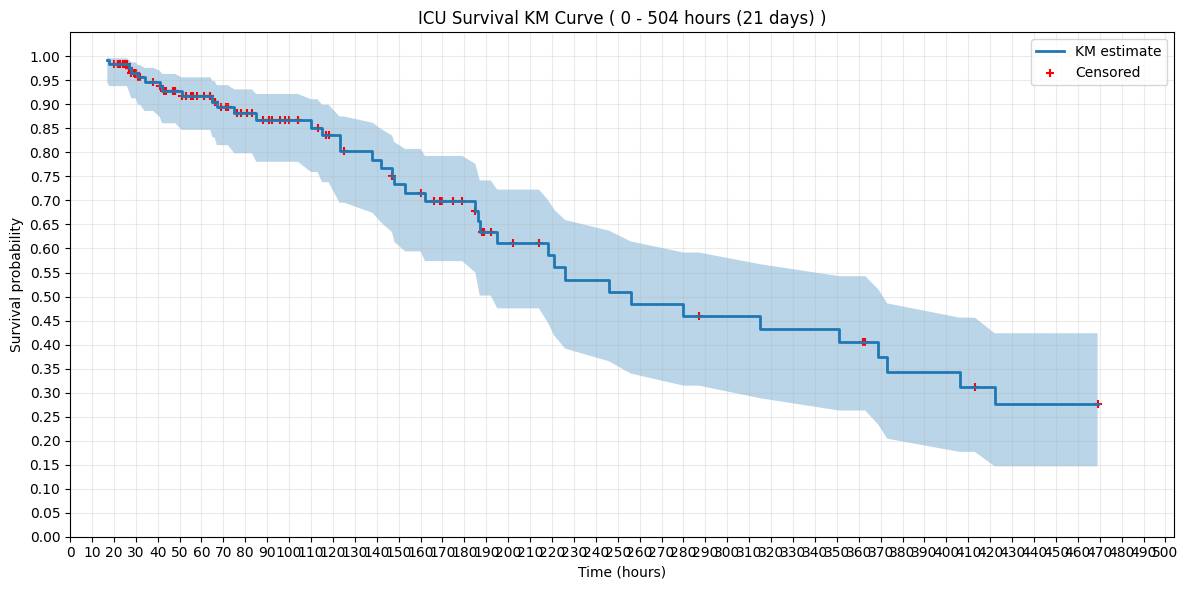

<Figure size 640x480 with 0 Axes>

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

def plot_km_curve(df: pd.DataFrame, max_time: int):
    """Plot Kaplan-Meier survival curve, truncated at max_time.
    Args:
        - df (pd.DataFrame): DataFrame containing 'LOS' and 'HOSPITAL_EXPIRE_FLAG' columns.
        - max_time (int): Maximum time to observe.
    """
    event = df['HOSPITAL_EXPIRE_FLAG'].to_numpy().astype(bool)
    time = df['LOS'].to_numpy()

    # KM estimator
    times, survival_prob, conf_int = kaplan_meier_estimator(event, time, conf_type="log-log")

    # 只保留 <= max_time 的部分
    mask = times <= max_time
    times = times[mask]
    survival_prob = survival_prob[mask]
    conf_int = conf_int[:, mask]

    plt.figure(figsize=(12,6))
    plt.step(times, survival_prob, where="post", label="KM estimate", linewidth=2)
    plt.fill_between(times, conf_int[0], conf_int[1], alpha=0.3)

    # 標示 censored (出院存活)
    censored_times = time[~event]
    censored_times = censored_times[censored_times <= max_time]  # 只留在 max_time 內的
    if len(censored_times) > 0:
        idx = np.searchsorted(times, censored_times, side="right") - 1
        idx = idx[idx >= 0]
        plt.scatter(censored_times, survival_prob[idx],
                    marker="+", color="red", label="Censored")

    plt.xlabel("Time (hours)")
    plt.ylabel("Survival probability")
    plt.title(f"ICU Survival KM Curve ( 0 - {max_time} hours ({max_time//24} days) )")
    plt.xlim(0, max_time)
    plt.ylim(0, 1.05)
    plt.yticks(np.arange(0, 1.05, 0.05))
    if max_time <= (14*24):
        plt.xticks(np.arange(0, max_time+1, 10))
    else:
        plt.xticks(np.arange(0, max_time+1, 20))
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"km_curve_{max_time//24}.png", dpi=300)

observe_time = [3,5,7,14,21]
for time in observe_time:
    max_time = time * 24
    plot_km_curve(patients, max_time=max_time)
